In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load data

In [3]:
import os
import numpy as np
import scipy.io

data_list = []

main_folder_path = '/content/drive/MyDrive/fSAE/'
sub_folders = ['1', '2', '3', '4']

folders = [os.path.join(main_folder_path, sub_folder) for sub_folder in sub_folders]


for folder in folders:
    for file in os.listdir(folder):
        if file.endswith('.mat'):
            mat_data = scipy.io.loadmat(os.path.join(folder, file))
            # Assuming the key in the .mat file is 'data_key'
            data_vector = mat_data['Y']
            # Flatten the vector before appending
            data_list.append(data_vector.ravel())
# Convert list to numpy array
data_array = np.array(data_list)


In [8]:
data_array.shape

(1200, 10000)

In [4]:
import os
import scipy.io

# Path to one of your .mat files for inspection
sample_mat_file_path = os.path.join('/content/drive/MyDrive/fSAE/1', '1.mat')  # Replace 'sample_file.mat' with the name of one of your .mat files

# Load the .mat file
mat_data = scipy.io.loadmat(sample_mat_file_path)

# Print the keys
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Y'])


model definition, set the training configuration and train model, model compilation, Model Evaluation and visualization

In [5]:
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Dropout
from keras.models import Model
from keras.regularizers import l2

input_dim = 10000
encoding_dim = 200  # Compressed representation

# Model Architecture with He Initialization
input_data = Input(shape=(input_dim,))

# Encoding layers with LeakyReLU and BatchNormalization
encoded = Dense(8000, kernel_initializer='he_normal')(input_data)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

encoded = Dense(4000, kernel_initializer='he_normal')(encoded)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

encoded = Dense(1000, kernel_initializer='he_normal')(encoded)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

encoded = Dense(encoding_dim, kernel_initializer='he_normal')(encoded)
encoded2 = LeakyReLU(alpha=0.01)(encoded)

# Decoding layers with LeakyReLU and BatchNormalization
decoded = Dense(1000, kernel_initializer='he_normal')(encoded2)
decoded = LeakyReLU(alpha=0.01)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.5)(decoded)

decoded = Dense(4000, kernel_initializer='he_normal')(decoded)
decoded = LeakyReLU(alpha=0.01)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.5)(decoded)

decoded = Dense(8000, kernel_initializer='he_normal')(decoded)
decoded = LeakyReLU(alpha=0.01)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.5)(decoded)

decoded = Dense(input_dim, activation='linear')(decoded)


# Create the autoencoder model
autoencoder2 = Model(inputs=input_data, outputs=decoded)

In [6]:
from keras.initializers import he_normal
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

optimizer2 = Adam(learning_rate=1e-3)  # You can adjust the learning rate here
autoencoder2.compile(optimizer=optimizer2, loss='mean_squared_error')

In [7]:
from keras.callbacks import ReduceLROnPlateau
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              verbose=1,
                              min_delta=1e-4,
                              mode='min')

shuffle and split data sets

In [8]:
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_array)

# Add small Gaussian noise
noise_factor = 0.0005  # Adjust this value based on your requirements
data_noisy = data_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_scaled.shape)

# Ensure the noisy data is still between 0 and 1
data_noisy = np.clip(data_noisy, 0., 1.)

# Split both the noisy data and the original scaled data
x_train_noisy, x_val_noisy, x_train, x_val = train_test_split(data_noisy, data_scaled, test_size=0.3, random_state=42)

In [9]:
history2= autoencoder2.fit(x_train_noisy, x_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_val_noisy, x_val),
                          callbacks=[reduce_lr])

Epoch 1/100
4/4 [==============================] - 45s 9s/step - loss: 1.7946 - val_loss: 99.1633 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 40s 10s/step - loss: 1.6558 - val_loss: 1045.8032 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 41s 11s/step - loss: 1.5373 - val_loss: 3304.5527 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 37s 9s/step - loss: 1.4308 - val_loss: 6466.3926 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 38s 9s/step - loss: 1.3441 - val_loss: 8807.3447 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 40s 10s/step - loss: 1.2555 - val_loss: 10387.6191 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 38s 10s/step - loss: 1.1619 - val_loss: 11735.4023 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 42s 10s/step - loss: 1.0941 - val_loss: 9561.3906 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 45s 11s/step - loss: 1.0192 - val_loss: 

In [22]:
history2_continue= autoencoder2.fit(x_train_noisy, x_train,
                          epochs=100,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_val_noisy, x_val),
                          callbacks=[reduce_lr])

Epoch 1/100
4/4 [==============================] - 48s 10s/step - loss: 0.4250 - val_loss: 0.0284 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 42s 10s/step - loss: 0.4213 - val_loss: 0.0280 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - 43s 11s/step - loss: 0.4208 - val_loss: 0.0276 - lr: 1.0000e-04
Epoch 4/100
4/4 [==============================] - 42s 10s/step - loss: 0.4169 - val_loss: 0.0277 - lr: 1.0000e-04
Epoch 5/100
4/4 [==============================] - 43s 10s/step - loss: 0.4159 - val_loss: 0.0281 - lr: 1.0000e-04
Epoch 6/100
4/4 [==============================] - 43s 10s/step - loss: 0.4147 - val_loss: 0.0281 - lr: 1.0000e-04
Epoch 7/100
4/4 [==============================] - 42s 10s/step - loss: 0.4134 - val_loss: 0.0278 - lr: 1.0000e-04
Epoch 8/100
4/4 [==============================] - 43s 11s/step - loss: 0.4105 - val_loss: 0.0279 - lr: 1.0000e-04
Epoch 9/100
4/4 [==============================] - 43s 10s/step - loss: 0.4094 -

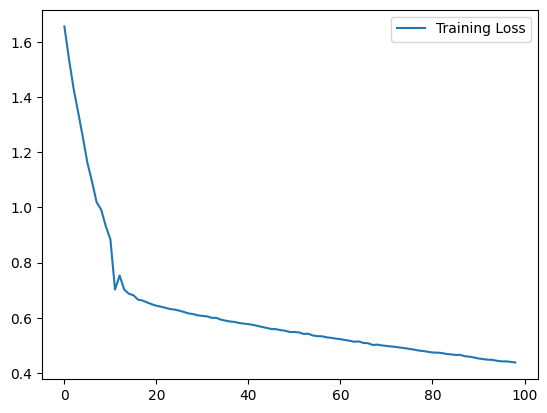

In [10]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'][1:], label='Training Loss')
#plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


do inference to get the data with reduced dimension

In [11]:
encoder = Model(input_data, encoded2)
compressed_data = encoder.predict(data_noisy)

38/38 [==============================] - 11s 284ms/step


save the obtained data

In [12]:
main_folder_path = '/content/drive/MyDrive/fSAE/'
compressed_folders = ["comp1", "comp2", "comp3", "comp4"]
samples_per_folder = 300

for idx, comp_folder in enumerate(compressed_folders):
    # Create the compressed folder if it doesn't exist
    comp_folder_path = os.path.join(main_folder_path, comp_folder)
    if not os.path.exists(comp_folder_path):
        os.makedirs(comp_folder_path)

    start_idx = idx * samples_per_folder
    end_idx = start_idx + samples_per_folder
    print(idx)
    for j, encoded_vector in enumerate(compressed_data[start_idx:end_idx]):
        file_name = f"{comp_folder}_{j+1}.mat"
        scipy.io.savemat(os.path.join(comp_folder_path, file_name), {'Y': encoded_vector})

0
1
2
3
